# Analytically solvable model
Author: Pietro Bonfa'

This example compares simulated and analytical results for a single mu-I interaction.

For the physical aspects, see A.Yaouanc and P. de Réotier, Muon Spin Rotation, Relaxation and Resonance,
Oxford University Press, 2010, chapter 7, Fig. 7.1.

In [1]:
try:
    from undi import MuonNuclearInteraction
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../undi')
    from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt
import numpy as np

Define physical constants.

In [2]:
angtom = 1.0e-10 # m, Angstrom.
elementary_charge = 1.6021766e-19 # Elementary charge, in Coulomb = Ampere*second.
epsilon0 = 8.8541878e-12 # Vacuum permittivity, in Ampere^2*kilogram^−1*meter^−3*second^4.
h = 6.6260693e-34 # J*s, Planck's constant.
hbar = h/(2*np.pi) # J*s, reduced Planck's constant.
mu0_over_4pi = 1e-7

Define the atomic positions for muon and Al nucleus.

In [3]:
mu_pos = np.array([  0  ,   0.,   0.])
I_pos  = np.array([ 0. ,   0.,    1.0])

gamma_mu = 2 * np.pi * 135.55e6
# Taking Al values, any number would do herei,
gamma_I = 6.976e7
I = 5/2 # spin of Al
Quadrupole_moment_I = 0.1466e-28 # m^2, quadrupole moment of Al.

wd = 0.11e6 # s^-1
wd_to_d = np.cbrt((mu0_over_4pi) * gamma_mu * gamma_I * hbar / wd)
omega_E = -1.1e6 # 1.1e6 # s^-1
omega_E_to_Vzz = omega_E * hbar * 4 * I * (2*I -1) / (Quadrupole_moment_I * elementary_charge)

# scale distance to get the expected omega_d
I_pos *= wd_to_d

Define the atomic structure. Note that positions are rotated first and then
transformed into Cartesian coordinates and SI units.

In [4]:
def gen_radial_EFG(p_mu, p_N, Vzz):
    x=p_N-p_mu
    n = np.linalg.norm(x)
    x /= n; r = 1. # keeping formula below for clarity
    return Vzz * ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 ) * 0.5
    # Final note, the last 0.5 is required since
    #  that the formula 
    #     ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 )
    # 
    #  would give for p_mu=np.array([0,0,0.]) and p_N=np.array([0,0,1.])
    #
    #    array([[ 1., -0., -0.],
    #           [-0.,  1., -0.],
    #           [-0., -0., -2.]])
    #
    # thus the largest eigenvalue is 2 (absolute value is intended),
    # that multiplied by Vzz would give 2Vzz.


atoms = [
        {'Position': mu_pos,
         'Label': 'mu'
        },
        {'Position': I_pos,
        'Label': '27Al',
        'Spin' : I,
        #'OmegaQmu': 3*omega_E
        'EFGTensor': gen_radial_EFG(mu_pos, I_pos, omega_E_to_Vzz),
        'ElectricQuadrupoleMoment': Quadrupole_moment_I
        }
    ]

## Polarization function.

The muon polarization is obtained with the method introduced by Celio.

In [5]:
steps = 200
tlist = np.linspace(0, 20e-6, steps) # Time scale, in seconds.

Define the applied external magnetic fields, in Tesla.

In [6]:
LongitudinalFields = np.array([0.0, 0.001, 0.00164, 0.003, 0.00329, 0.004, 0.005, 0.006, 0.007])

#This is the Celio method for the polarization function with positive EFG.
print("Computing signal for positive EFGs...", end='', flush=True)

signI_positive_EFG = np.zeros([len(LongitudinalFields), steps]) # Define the polarization signal with positive EFGs.

for i, B in enumerate(LongitudinalFields):

    # Align the external field along z i.e. parallel to the muon spin.
    B_pos = B*np.array([0.,0.,1.])

    NS = MuonNuclearInteraction(atoms, external_field=B_pos, log_level='warn')
    
    repeat = int(np.ceil(10/NS.Hdim))
    for _ in range(repeat):
        # use Celio
        #signI_positive_EFG[i] += NS.celio(tlist,  k=1)
        # or exact alternative
        signI_positive_EFG[i] += NS.polarization(tlist)


    del NS
signI_positive_EFG /= repeat
print('done!')

Computing signal for positive EFGs...done!


The Hamiltonian describing I-mu interaction is

$$
\mathcal{H}_{\mathrm{tot}}=\hbar\left\{-\frac{\omega_{\mu}}{2} \sigma^{Z}-\omega_{I} I^{Z}+3 \omega_{\mathrm{E}}\left[\left(I^{Z}\right)^{2}-\frac{I(I+1)}{3}\right]+\frac{\omega_{I, \mathrm{~d}}}{2}\left[\boldsymbol{\sigma} \cdot \mathbf{I}-3 I^{Z} \sigma^{Z}\right]\right\}
$$

where

$$
\omega_{I, \mathrm{d}}=\frac{\mu_{0}}{4 \pi} \frac{\gamma_{\mu} \gamma_{I} \hbar}{r_{I}^{3}} \quad \omega_{I} = \gamma_I B  \quad \omega_{\mu} = \gamma_\mu B
$$

and

$$
\hbar \omega_E = \frac{e^{2} q_{i} Q_{i}}{4 I_{i}\left(2 I_{i}-1\right)} 
$$

The solution is

$$
\begin{array}{c}
R_{m}=\frac{\omega_{I, \mathrm{~d}}}{2} \sqrt{I(I+1)-m(m-1)}, \quad S_{m}=(2 m-1)\left(3 \omega_{\mathrm{E}}+\frac{\omega_{I, \mathrm{~d}}}{2}\right)-\omega_{I}+\omega_{\mu}, \\
P_{Z}(t)=\frac{1}{2 I+1} \sum_{m} \frac{S_{m}^{2}+R_{m}^{2} \cos \left(\sqrt{S_{m}^{2}+R_{m}^{2}} t\right)}{S_{m}^{2}+R_{m}^{2}}
\end{array}
$$

But there is a factor 2 popping up in $\omega_d$, also in the book.

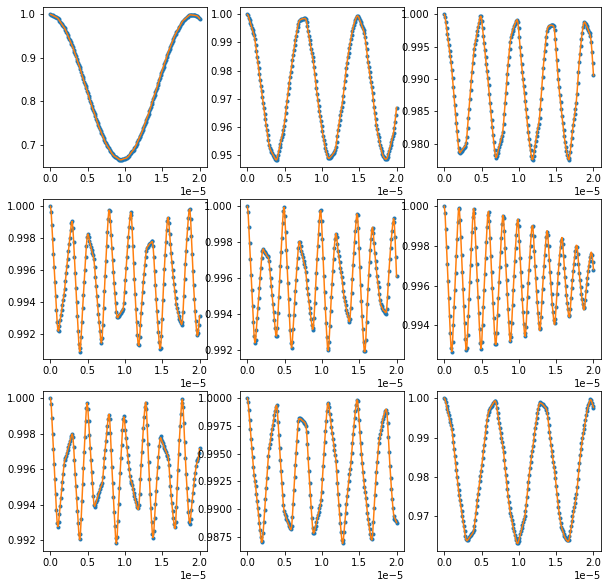

In [7]:
rm = lambda wid, I, m: (wid/2.) * np.sqrt(I*(I+1) - m*(m-1))
sm = lambda we, wid, wi,wmu, m: (2*m-1)*(3*we+wid/2) - wi + wmu

def pz(t, I, wid, we, B=0):
    s = np.zeros_like(t)
    wi  = gamma_I * B * 1e-6
    wmu = gamma_mu * B * 1e-6
    for m in np.arange(-I,I+1,1):
        s2 = (sm(we, wid, wi, wmu, m))**2
        r2 = (rm(wid,I,m))**2
        s += (s2 + r2 * np.cos(np.sqrt(s2+r2)*t))/(s2+r2)
    s /= (2*I+1)
    return s

f, axes = plt.subplots(nrows=3,ncols=3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        l = i+j*3
        axes[j,i].plot(tlist, signI_positive_EFG[l],'.')
        # Set values in us^-1
        axes[j,i].plot(tlist, pz(tlist*1e6,I,2*wd*1e-6,omega_E*1e-6,B=LongitudinalFields[l]))